In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import norm

In [2]:

class CausalGenerator:
    def __init__(self, graph, data,unit_vars,subunit_vars,sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.processed_data = self.preprocess_data(unit_vars,subunit_vars,sizes)
        
    def preprocess_data(self,unit_vars,subunit_vars,sizes):
        # Aggregate subunit nodes
        data = {}
        
        for var in unit_vars:
            for i in range(len(sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in subunit_vars:
            for i in range(len(sizes)):
                s=0
                for j in range(sizes[i]):
                    s+=self.data['_'+var+str(i)+'_'+str(j)]
            data[var] = s/sizes[i]
        return data
    
    
    def generate(self, noise_dist, transition_funcs, sizes):
        generated = {}
        for node in nx.topological_sort(self.graph):
            for i in range(len(sizes)):
                x=np.random.uniform()
                parents = list(self.graph.predecessors(node))
                if not parents:
                    generated[node+str(i)] = noise_dist[node](x)
                else:
                    parent_values = [generated[p+str(i)] for p in parents]
                    generated[node+str(i)] = transition_funcs[node](*parent_values) + noise_dist[node](x)
        
        # Convert to pandas DataFrame
        return generated
        

In [12]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [13]:
data = load_data_from_json('data/sampled_data.json')


Data successfully loaded from data/sampled_data.json


In [14]:

# Example usage:
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]

unit_vars = ['a', 'c', 'e']
subunit_vars = ['d', 'b']
sizes = [50]*50

generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
noise_dist = {
    'a': lambda x: norm.ppf(x),
    '_b': lambda x: norm.ppf(x, loc=0, scale=1),
    'c': lambda x: norm.ppf(x, loc=0, scale=1),
    '_d': lambda x: norm.ppf(x, loc=0, scale=1),
    'e': lambda x: norm.ppf(x, loc=0, scale=1)
}

transition_funcs = {
    '_b': lambda a: a,
    'c': lambda a, b: a**3 + (b+1)**2,
    '_d': lambda b, c: b+1 - c,
    'e': lambda c, d: c + d+1
}

In [15]:

generated_data = generator.generate(noise_dist, transition_funcs,sizes)

In [16]:
print(generated_data)


{'a0': 0.08138798270238999, 'a1': -1.964674690358758, 'a2': -1.3572350682528826, 'a3': -0.15526182957053888, 'a4': 0.3920475398010506, 'a5': -0.25348061585891346, 'a6': 0.957496004653132, 'a7': -0.024360210624095588, 'a8': 1.3155890656611051, 'a9': 1.0611088409306997, 'a10': 1.010784249053097, 'a11': -1.1552507726060788, 'a12': -2.174670966206903, 'a13': 1.974760939507873, 'a14': -1.5461178278952066, 'a15': 1.7659243888706415, 'a16': -0.08528656088628275, 'a17': 0.2852261951856869, 'a18': 0.9817871775271081, 'a19': -0.9803064504380762, 'a20': 0.2278371699406851, 'a21': 0.5561596805837109, 'a22': 2.3926075124010784, 'a23': -0.6326721512822551, 'a24': -0.2862749715146723, 'a25': -0.049690286913926636, 'a26': 1.6472801097107892, 'a27': -1.0319410374337898, 'a28': 0.12654536109746384, 'a29': 0.011674024988164467, 'a30': -0.6552628521310536, 'a31': -0.5971020851862884, 'a32': 1.9227787754979193, 'a33': 0.4590371303088403, 'a34': 0.12042019086550526, 'a35': -1.793271200585099, 'a36': -0.6248

In [17]:
# Generate arrays for each variable
a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]

# Print the arrays
print("a arrays:", a_array)
print("b arrays:", b_array)
print("c arrays:", c_array)
print("d arrays:", d_array)
print("e arrays:", e_array)


a arrays: [0.08138798270238999, -1.964674690358758, -1.3572350682528826, -0.15526182957053888, 0.3920475398010506, -0.25348061585891346, 0.957496004653132, -0.024360210624095588, 1.3155890656611051, 1.0611088409306997, 1.010784249053097, -1.1552507726060788, -2.174670966206903, 1.974760939507873, -1.5461178278952066, 1.7659243888706415, -0.08528656088628275, 0.2852261951856869, 0.9817871775271081, -0.9803064504380762, 0.2278371699406851, 0.5561596805837109, 2.3926075124010784, -0.6326721512822551, -0.2862749715146723, -0.049690286913926636, 1.6472801097107892, -1.0319410374337898, 0.12654536109746384, 0.011674024988164467, -0.6552628521310536, -0.5971020851862884, 1.9227787754979193, 0.4590371303088403, 0.12042019086550526, -1.793271200585099, -0.6248421906647278, -0.5031704351273282, -1.1294542211068341, 0.7801538429107076, -1.7179623927004217, 0.6948318193297349, -1.2510944239160993, -2.530343756931086, 0.3281955588290728, -1.1217062738287293, 0.2570775260735626, -0.27043902369003087

In [18]:
original_e = [data['e'+str(k)] for k in range(len(sizes))]

In [19]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad


In [20]:

def kl_divergence(p, q):
    def integrand(x):
        px = p(x)
        qx = q(x)
        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-10
        return np.where((px > 0) & (qx > 0),
                        px * (np.log(px + epsilon) - np.log(qx + epsilon)),
                        0)
    
    result, _ = quad(integrand, -np.inf, np.inf, limit=1000)
    return result


In [21]:

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))

In [34]:

# Select two arrays for comparison
array1 = e_array  # First array from e_arrays
array2 = [data[f'e{i}'] for i in range(50)]  # Second array from the original data

arrayA = [data[f'a{i}'] for i in range(50)]  # Second array from the original data
arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
arrayC = [data[f'c{i}'] for i in range(50)]  # Second array from the original data



arrayB_full = np.array([[data[f'_b{i}_{j}'] for i in range(50)] for j in range(50)])  # Second array from the original data
arrayD_full =np.array([[data[f'_d{i}_{j}'] for i in range(50)] for j in range(50)])   # Second array from the original data

In [23]:

# Compute KL divergence
kl_div = kl_divergence(array1, array2)

# Print the KL divergence
print(f"KL divergence between the two arrays E: {kl_div}")
 # high kl div okay
 
kl_div = kl_divergence(arrayA, a_array)
print(f"KL divergence between the two arrays A: {kl_div}")

kl_div = kl_divergence(arrayB, b_array)
print(f"KL divergence between the two arrays B: {kl_div}")

kl_div = kl_divergence(arrayC, c_array)
print(f"KL divergence between the two arrays C: {kl_div}")

KL divergence between the two arrays E: 7.395117200009947
KL divergence between the two arrays A: 0.009272755018228291
KL divergence between the two arrays B: 0.1103759590786843
KL divergence between the two arrays C: 0.07598128282904118


/tmp/ipykernel_3109/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_3109/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


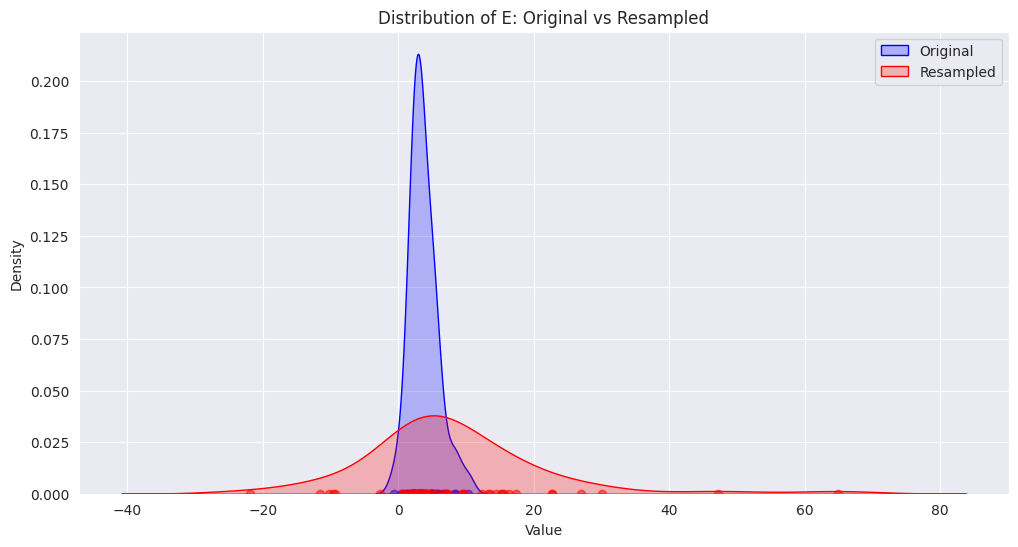

/tmp/ipykernel_3109/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_3109/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


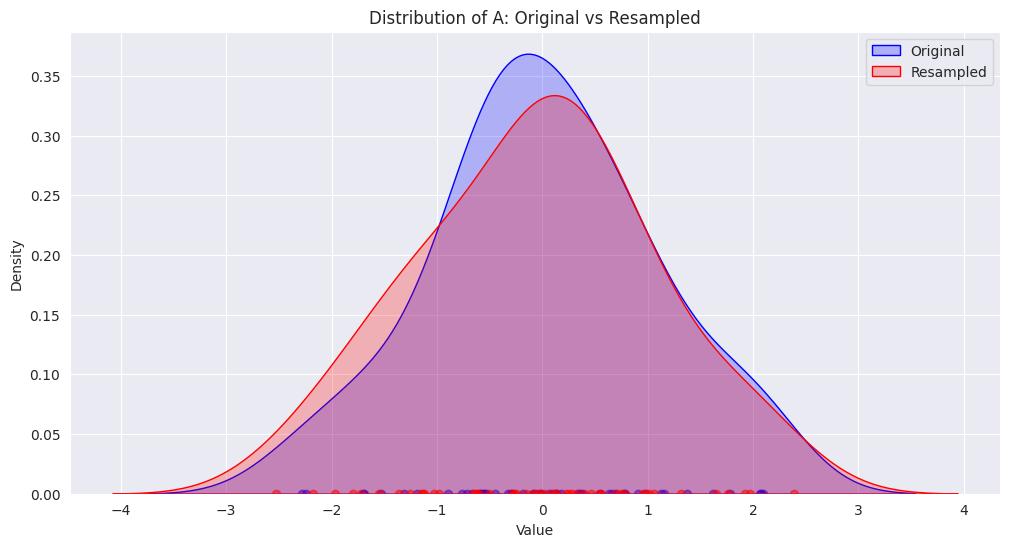

/tmp/ipykernel_3109/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_3109/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


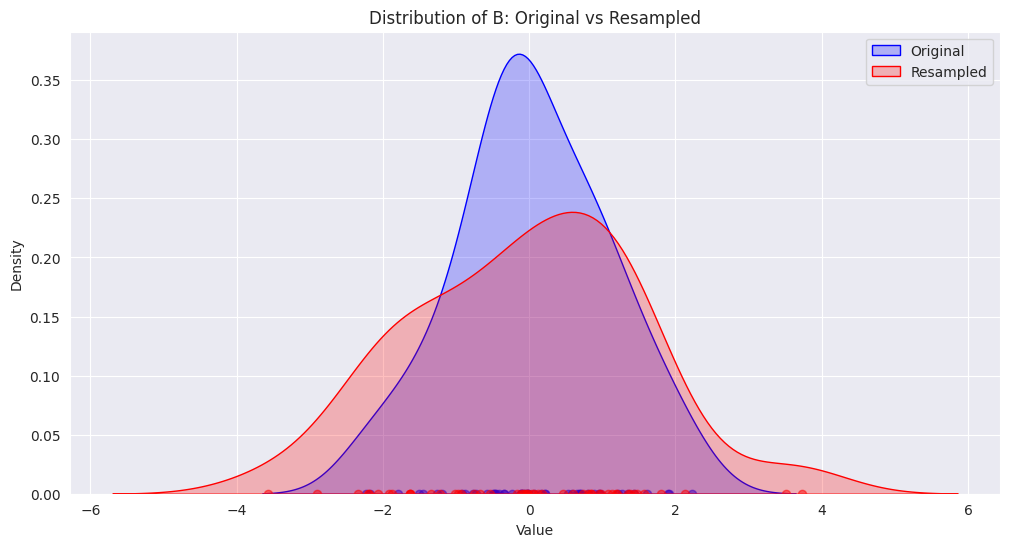

/tmp/ipykernel_3109/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_3109/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


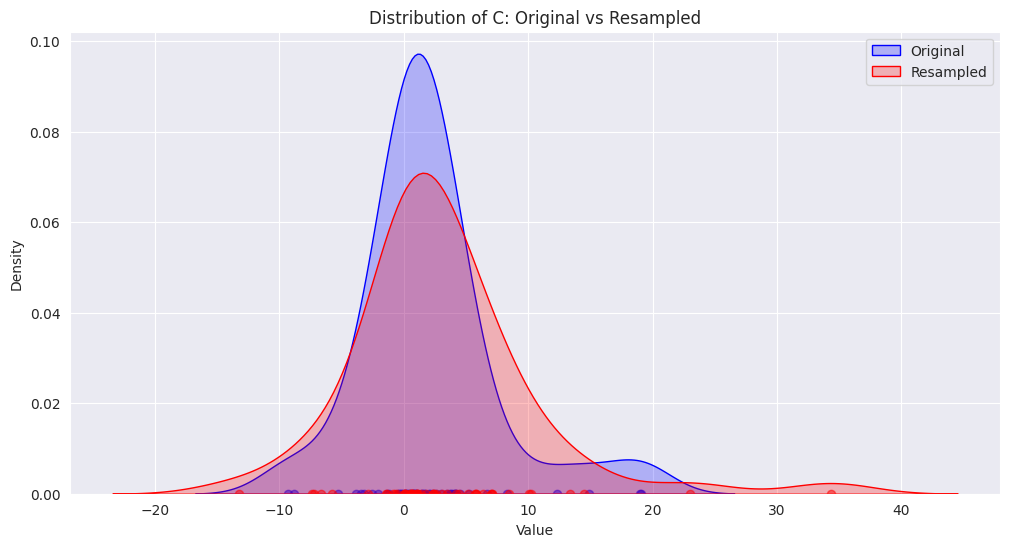

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_arrays_with_kde(original, resampled, title):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    sns.kdeplot(original, shade=True, color="blue", label="Original")
    plt.scatter(original, [0]*len(original), color="blue", alpha=0.5)
    
    # Plot resampled data
    sns.kdeplot(resampled, shade=True, color="red", label="Resampled")
    plt.scatter(resampled, [0]*len(resampled), color="red", alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot for E
plot_arrays_with_kde(array2, array1, "Distribution of E: Original vs Resampled")

# Plot for A
plot_arrays_with_kde(arrayA, a_array, "Distribution of A: Original vs Resampled")

# Plot for B
plot_arrays_with_kde(arrayB, b_array, "Distribution of B: Original vs Resampled")

# Plot for C
plot_arrays_with_kde(arrayC, c_array, "Distribution of C: Original vs Resampled")


In [25]:
def experiment(n):
    kldivs= []
    for k in range(n):
        # Example usage:
        graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
        data = load_data_from_json(f'data/sampled_data_{k}.json')
        print(str(k) + " is in progress")
        
        unit_vars = ['a', 'c', 'e']
        subunit_vars = ['d', 'b']
        sizes = [50]*50
        
        generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
        noise_dist = {
            'a': lambda x: norm.ppf(x),
            '_b': lambda x: norm.ppf(x, loc=0, scale=1),
            'c': lambda x: norm.ppf(x, loc=0, scale=1),
            '_d': lambda x: norm.ppf(x, loc=0, scale=1),
            'e': lambda x: norm.ppf(x, loc=0, scale=1)
        }
                
        transition_funcs = {
            '_b': lambda a: a,
            'c': lambda a, b: a**3 + (b+1)**2,
            '_d': lambda b, c: b+1 - c,
            'e': lambda c, d: c + d+1
        }
                
            
        generated_data = generator.generate(noise_dist, transition_funcs,sizes)

            # Generate arrays for each variable
        a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
        b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
        c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
        d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
        e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]
            
            
        # Select two arrays for comparison
        array1 = e_array  # First array from e_arrays
        array2 = [data[f'e{i}'] for i in range(50)]  # Second array from the original data
        
        arrayA = [data[f'a{i}'] for i in range(50)]  # Second array from the original data
        arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
        arrayC = [data[f'c{i}'] for i in range(50)]  # Second array from the original data
        
        arrayD = [np.mean(np.array([data[f'_d{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
        
        kldiv = {'c': kl_divergence(arrayC, c_array), 'b': kl_divergence(arrayB, b_array), 'a': kl_divergence(arrayA, a_array), 'd': kl_divergence(arrayD, d_array), 'e': kl_divergence(array2, array1)}
        
        
        kldivs.append(kldiv)
        
    return kldivs





    

In [26]:
kldivs = experiment(100)

Data successfully loaded from data/sampled_data_0.json
0 is in progress
Data successfully loaded from data/sampled_data_1.json
1 is in progress
Data successfully loaded from data/sampled_data_2.json
2 is in progress
Data successfully loaded from data/sampled_data_3.json
3 is in progress
Data successfully loaded from data/sampled_data_4.json
4 is in progress
Data successfully loaded from data/sampled_data_5.json
5 is in progress
Data successfully loaded from data/sampled_data_6.json
6 is in progress
Data successfully loaded from data/sampled_data_7.json
7 is in progress
Data successfully loaded from data/sampled_data_8.json
8 is in progress
Data successfully loaded from data/sampled_data_9.json
9 is in progress
Data successfully loaded from data/sampled_data_10.json
10 is in progress
Data successfully loaded from data/sampled_data_11.json
11 is in progress
Data successfully loaded from data/sampled_data_12.json
12 is in progress
Data successfully loaded from data/sampled_data_13.json
13

/tmp/ipykernel_3109/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_3109/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_3109/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_3109/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, a

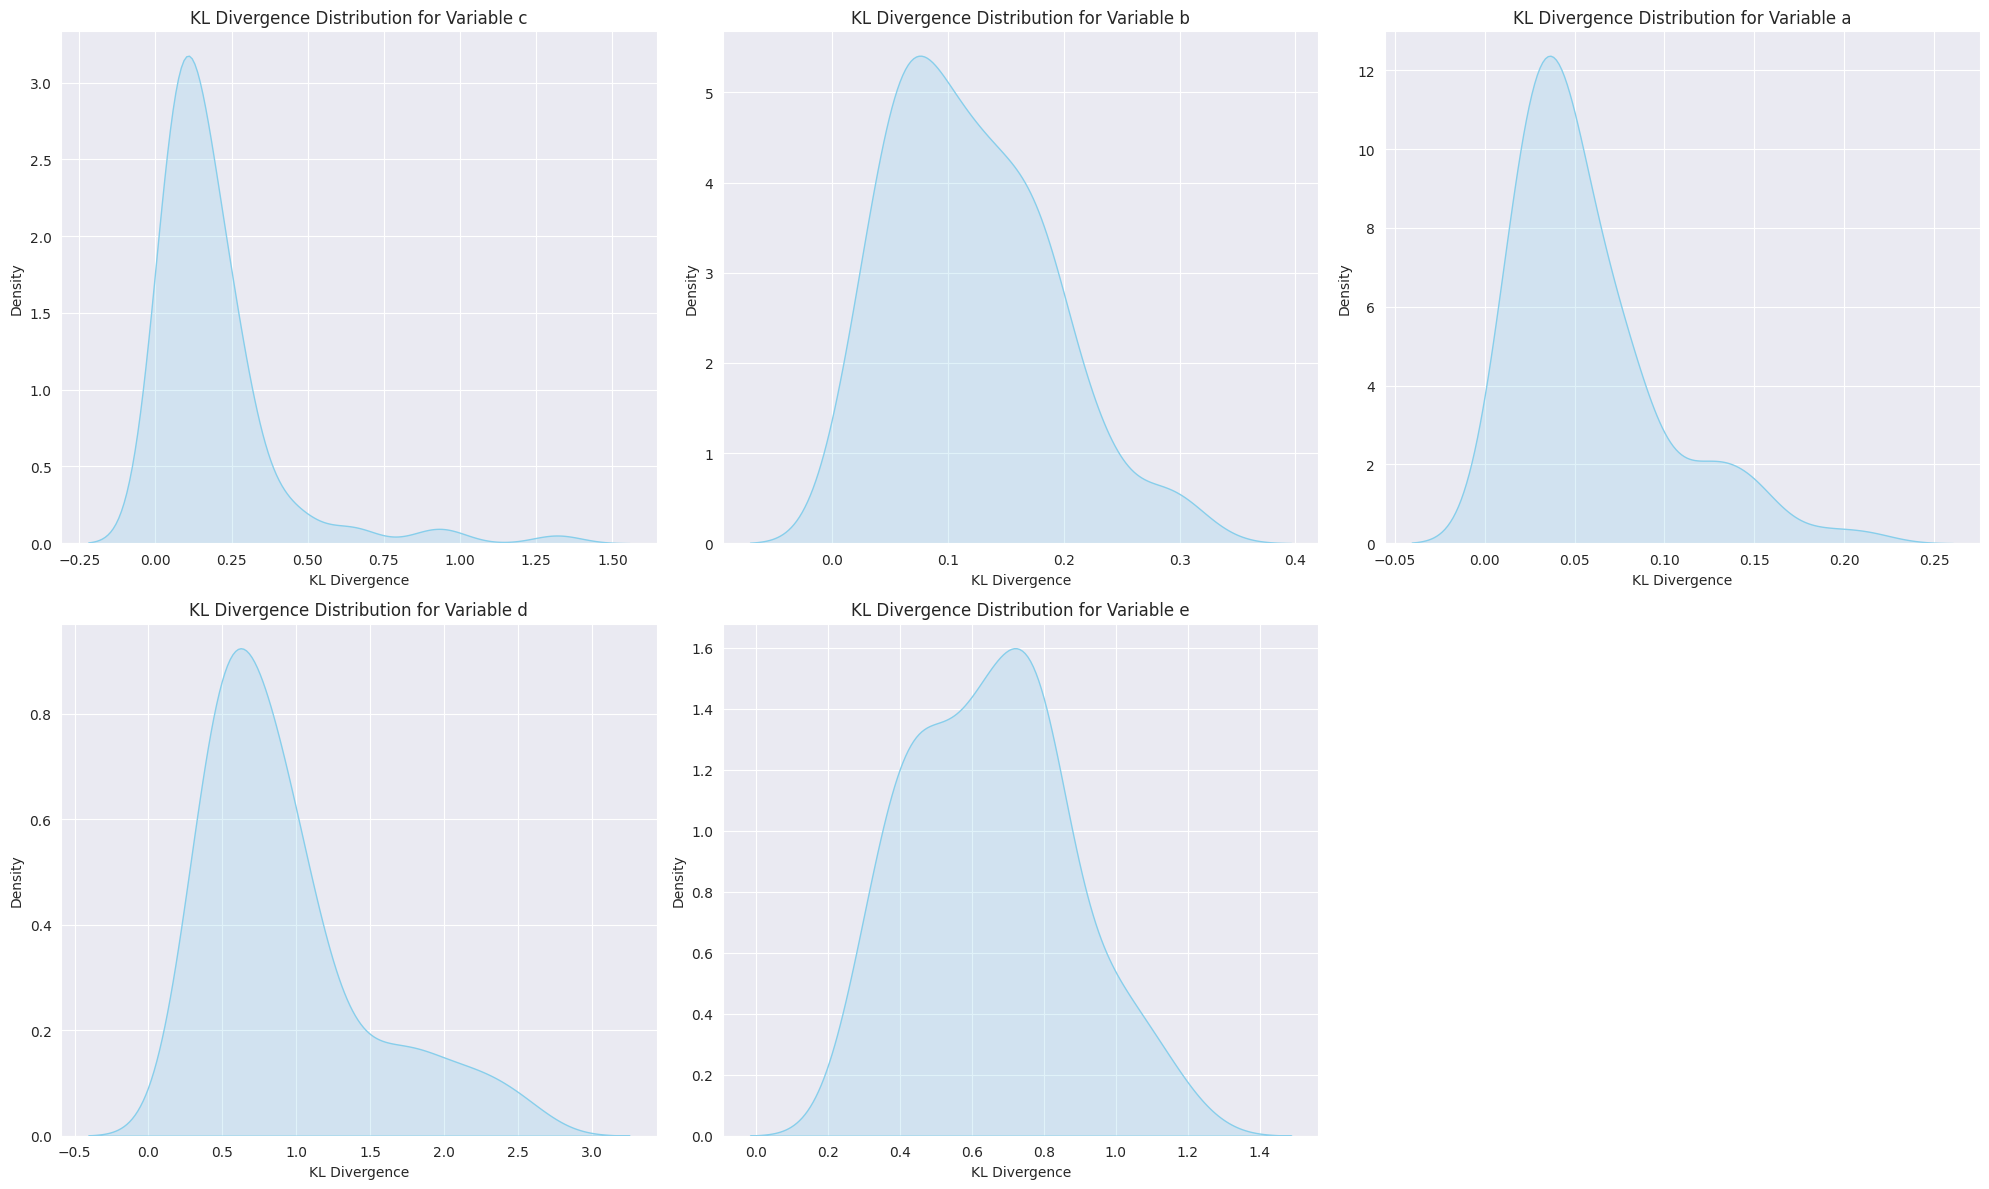

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kldivs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kldivs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [28]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kldivs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


Variable c:
  Mean KL Divergence: 0.1848
  Standard Deviation: 0.1981

Variable b:
  Mean KL Divergence: 0.1189
  Standard Deviation: 0.0680

Variable a:
  Mean KL Divergence: 0.0574
  Standard Deviation: 0.0411

Variable d:
  Mean KL Divergence: 0.9274
  Standard Deviation: 0.5536

Variable e:
  Mean KL Divergence: 0.6548
  Standard Deviation: 0.2198



In [35]:
print(arrayB_full)

[[-2.20945678e+00  1.09939838e+00 -9.09853842e-01 ...  1.80937173e+00
   3.75224831e-01 -2.45821230e-01]
 [-4.17898983e+00 -1.55784320e+00 -6.54495971e-01 ...  9.42392786e-01
   1.41059015e+00 -8.35620760e-01]
 [-1.49795885e+00  1.35655962e+00 -1.04739973e+00 ... -5.15904263e-01
   4.36612711e-01 -8.79460939e-01]
 ...
 [-1.73497103e+00  2.80483001e-01 -3.83148191e-01 ...  8.10959567e-01
   1.67992596e+00  4.58452059e-02]
 [-1.23184130e+00  2.52837544e-02 -1.27752822e+00 ... -5.87962262e-01
  -2.34303026e-03 -1.86963717e+00]
 [-3.66966592e+00  8.80204072e-01 -1.90042469e+00 ...  1.02352917e-01
  -1.35520393e-01  2.39852838e-02]]


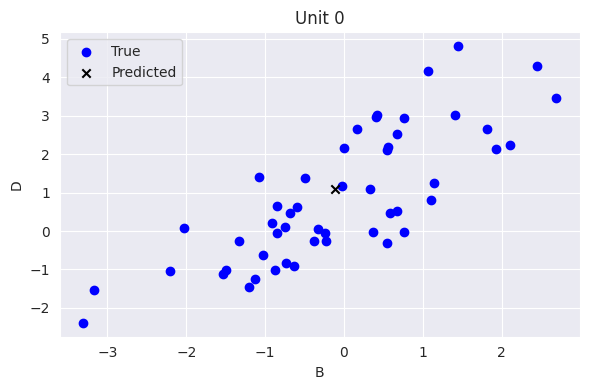

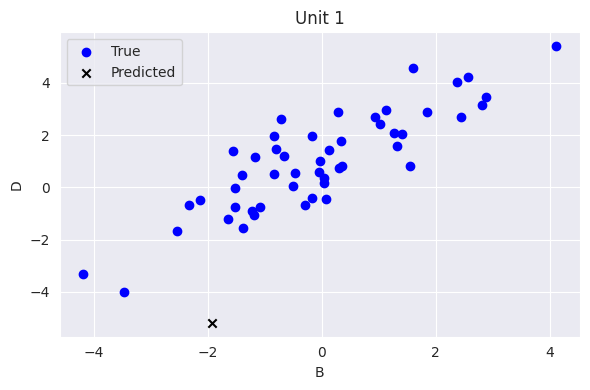

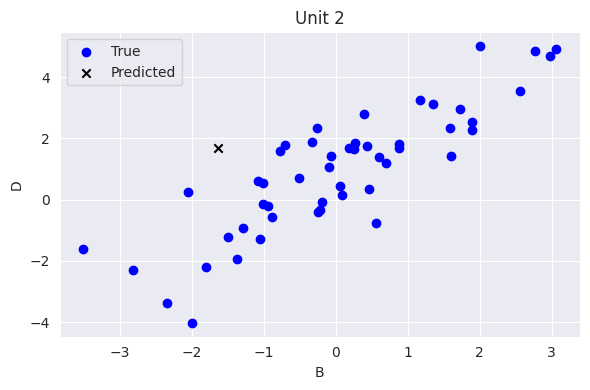

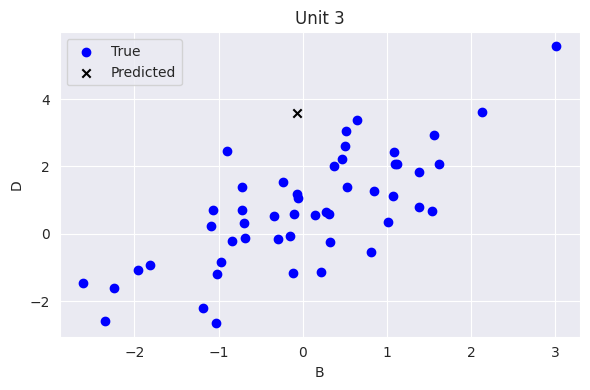

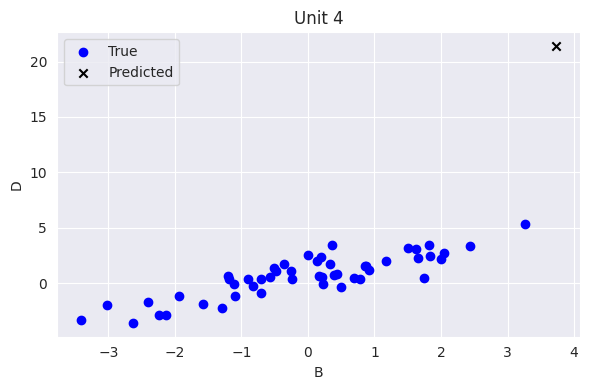

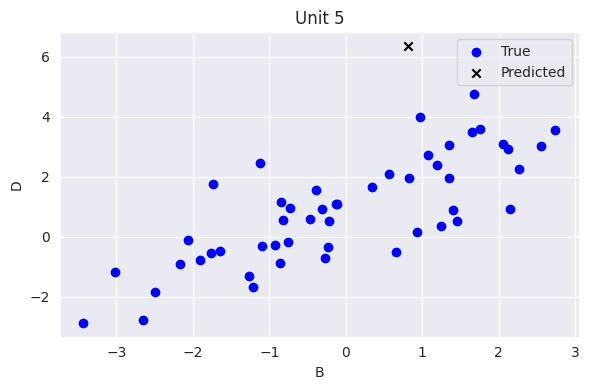

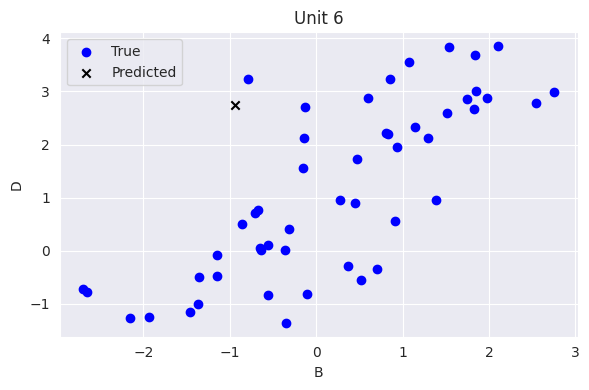

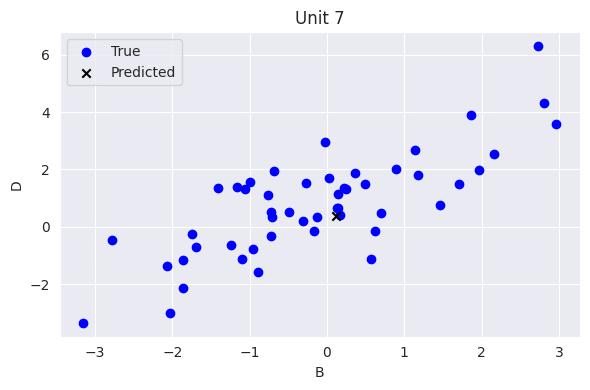

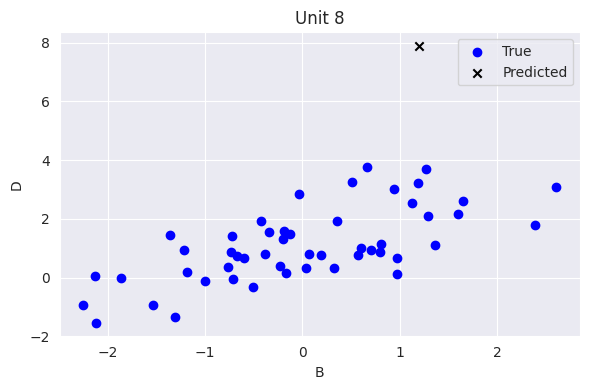

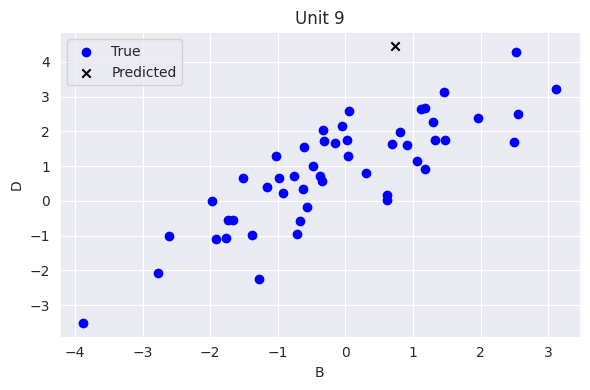

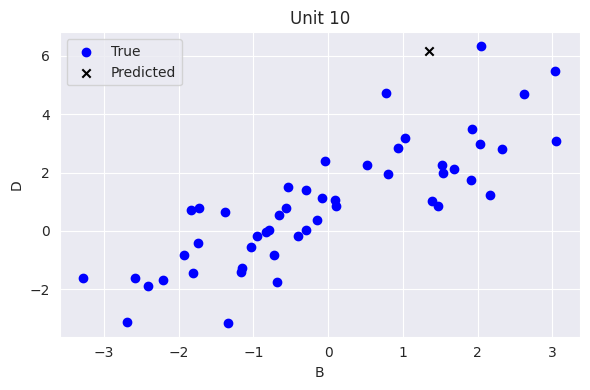

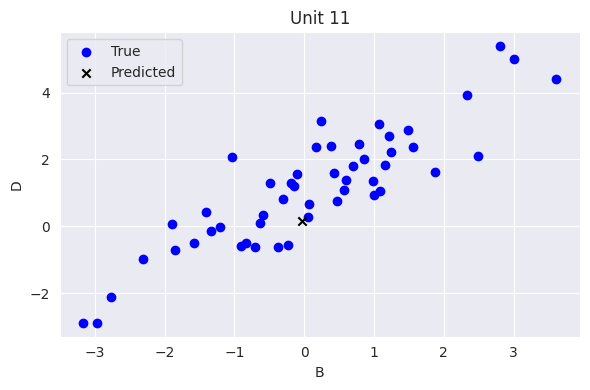

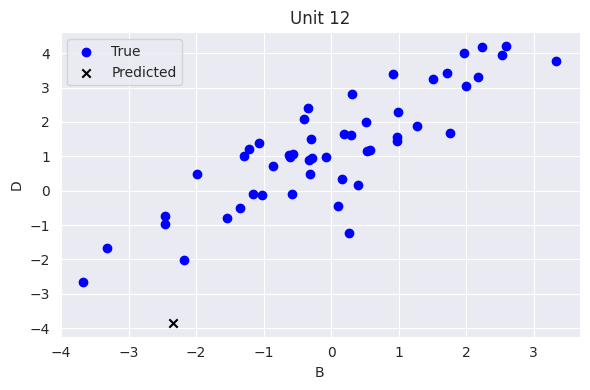

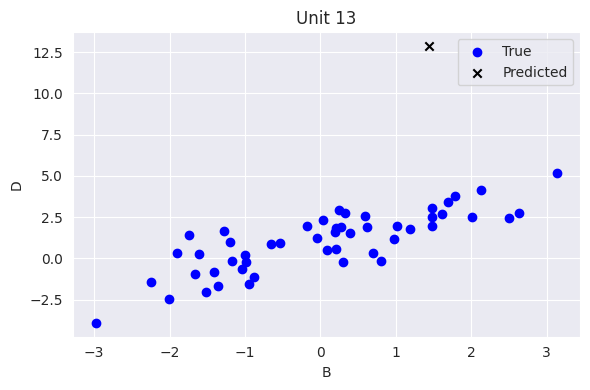

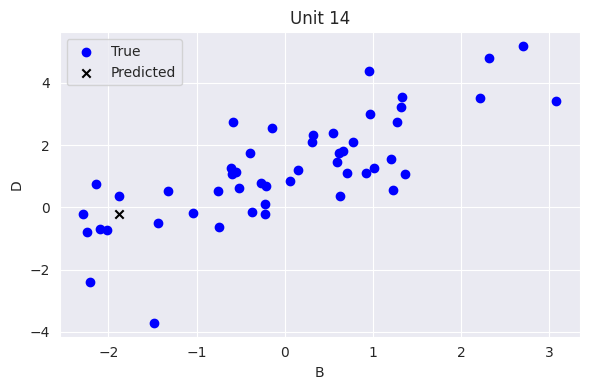

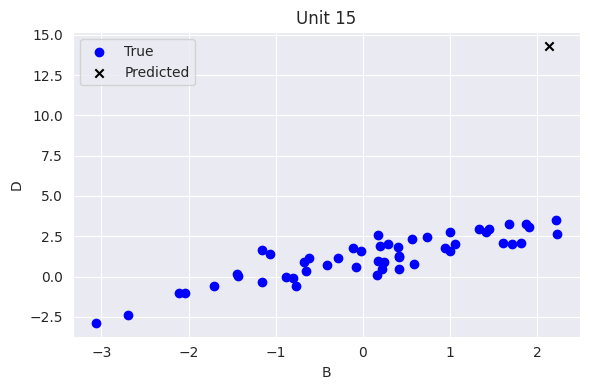

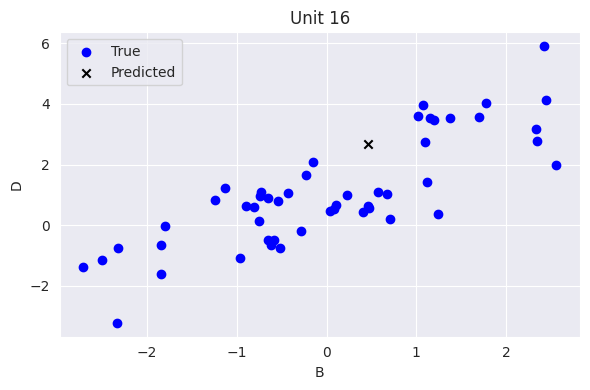

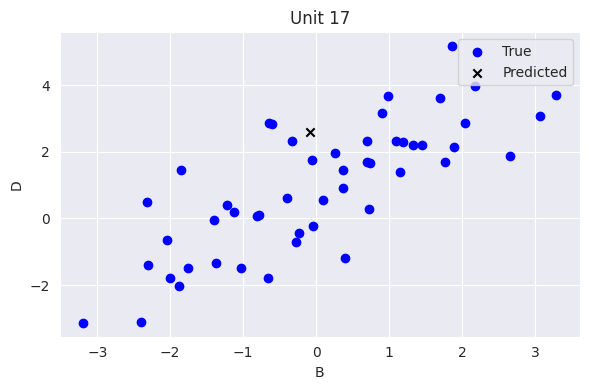

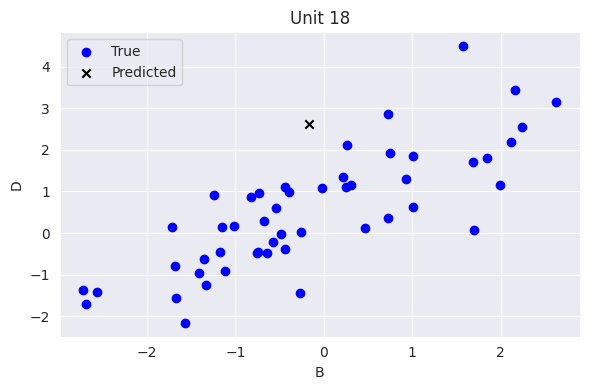

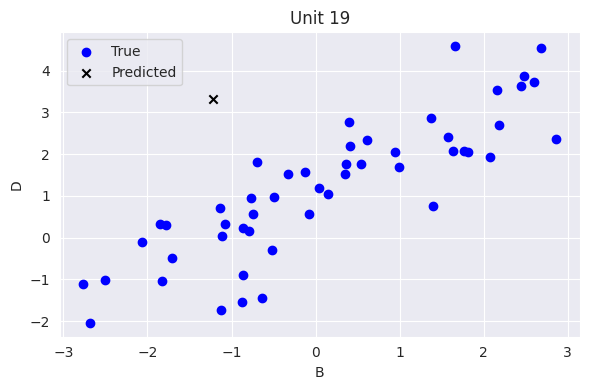

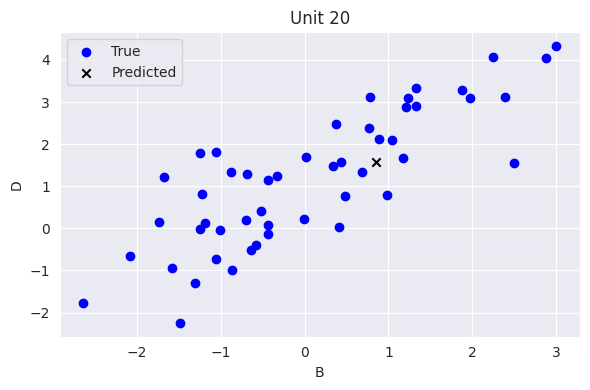

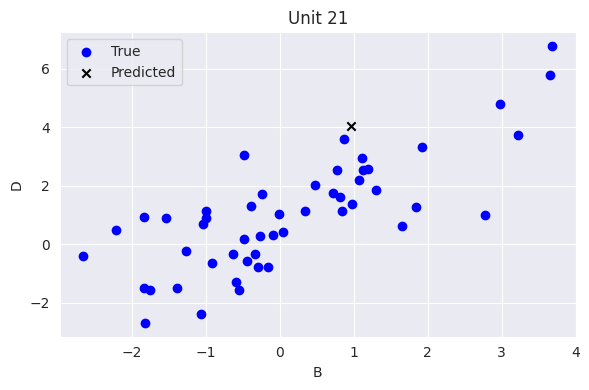

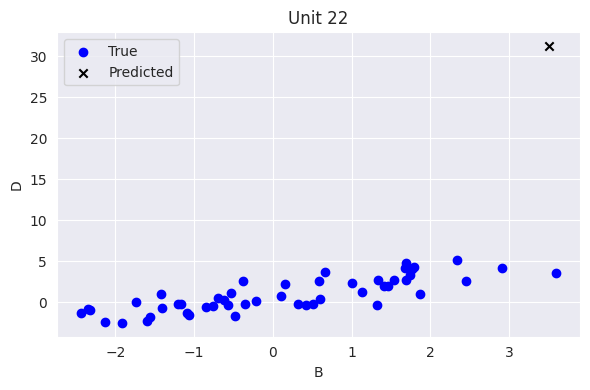

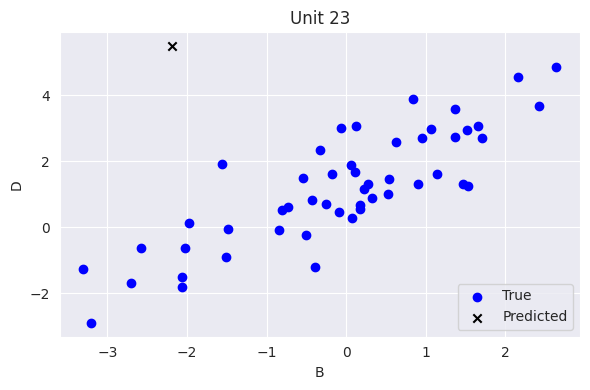

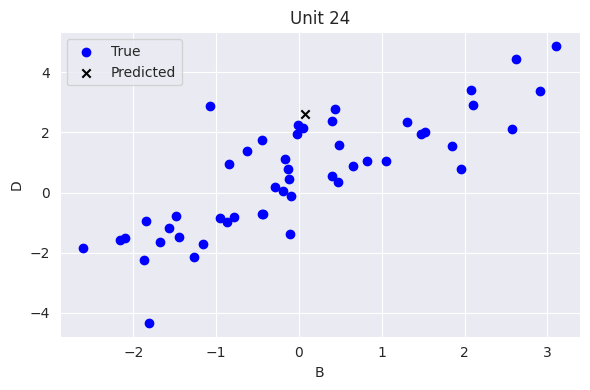

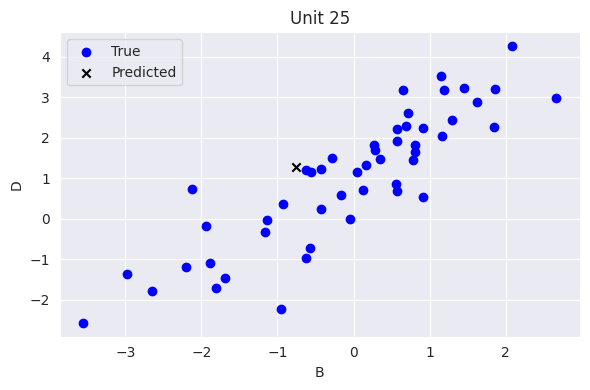

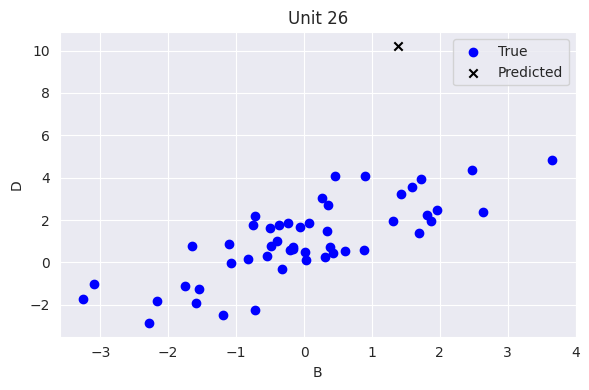

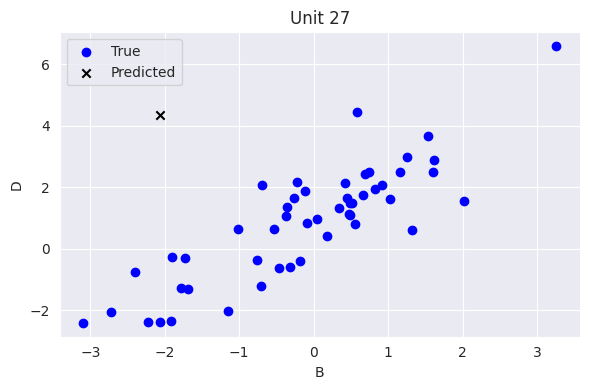

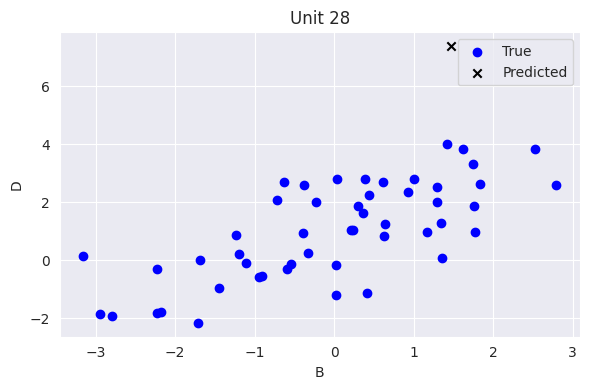

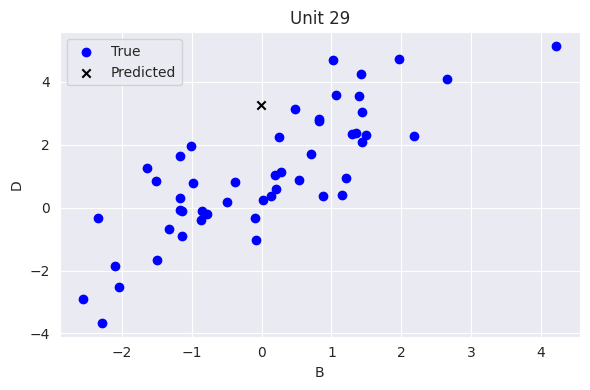

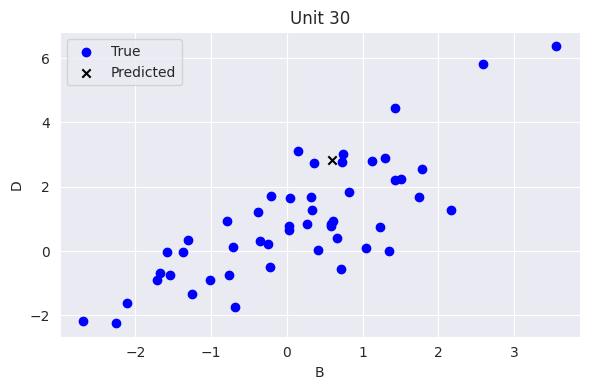

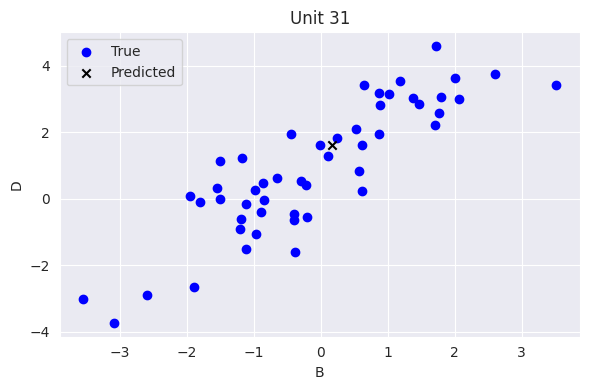

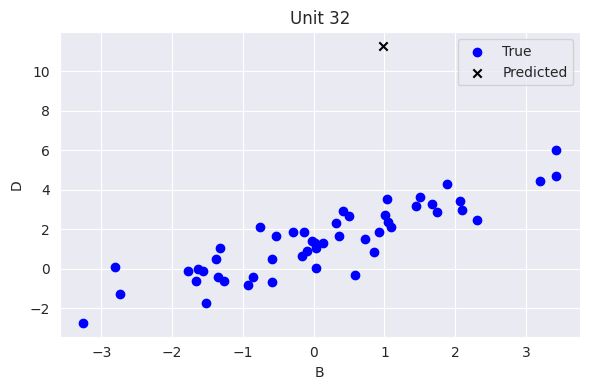

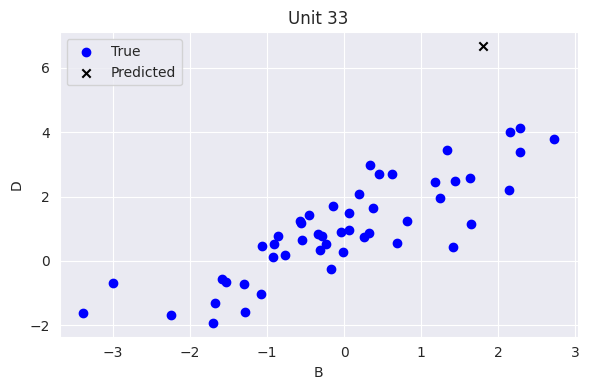

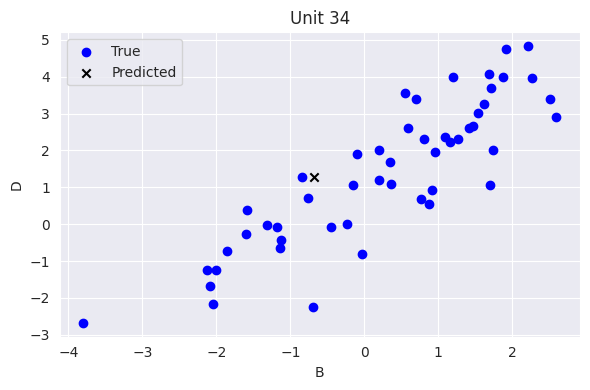

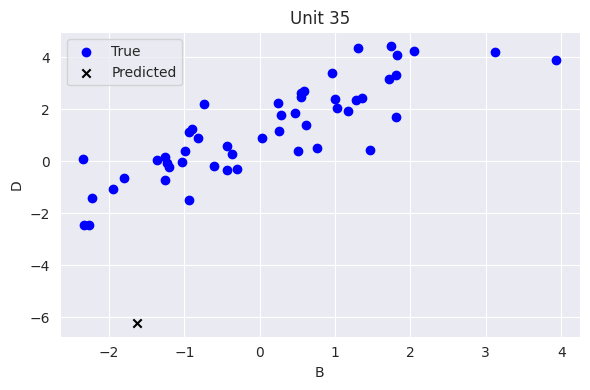

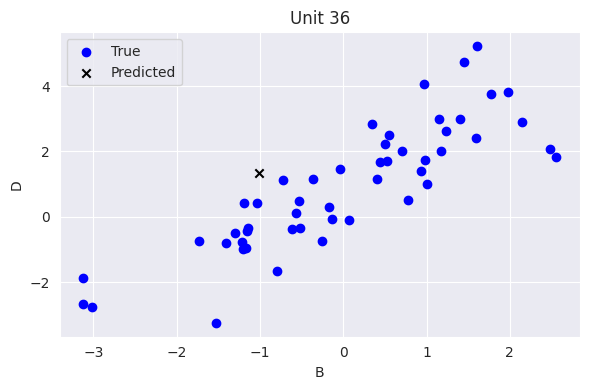

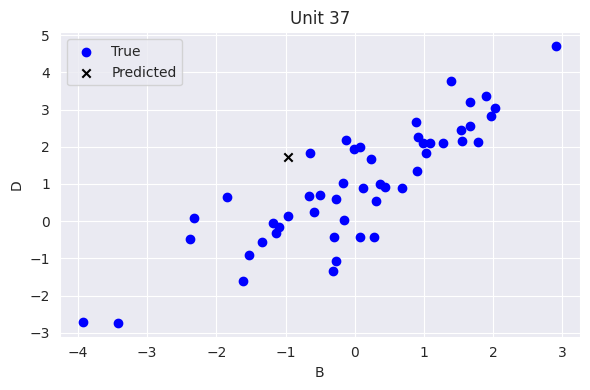

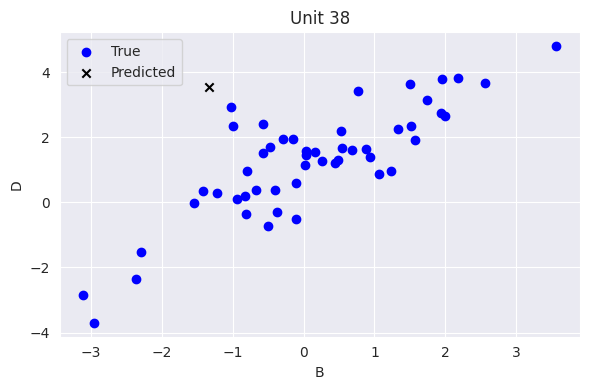

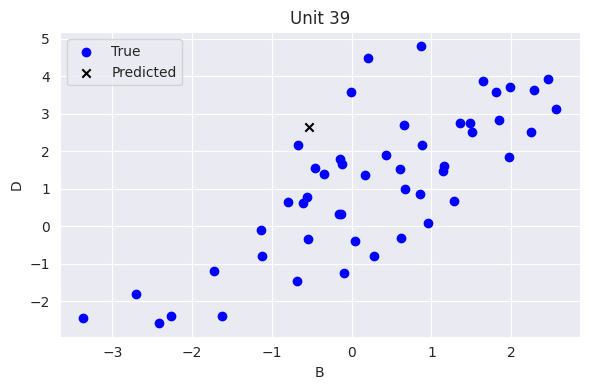

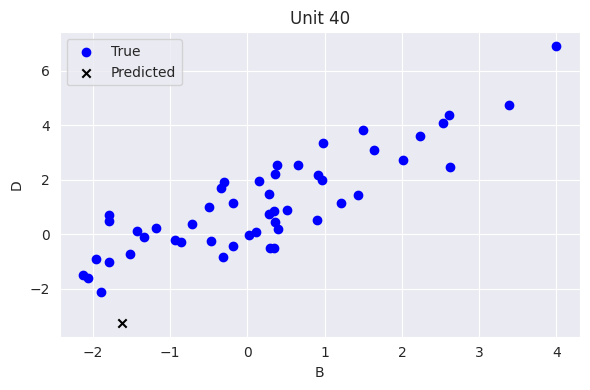

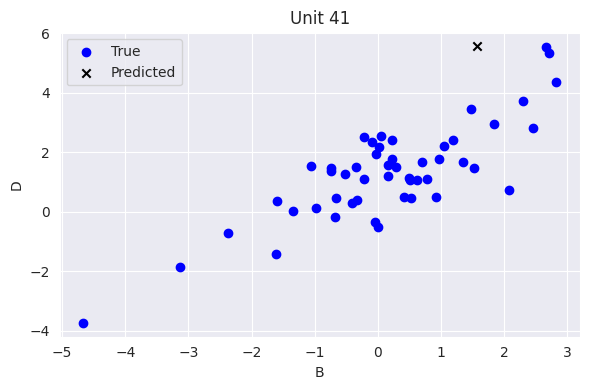

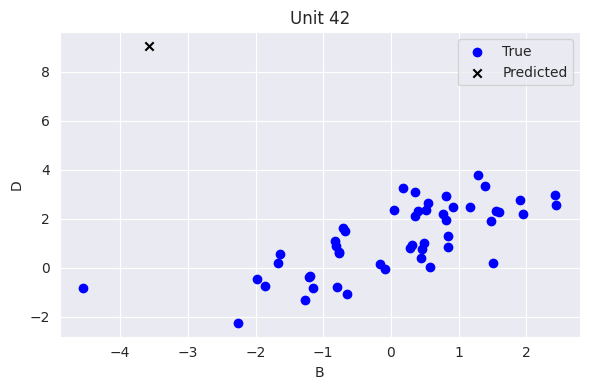

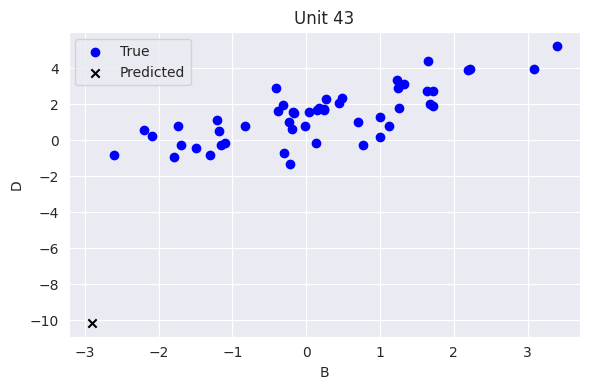

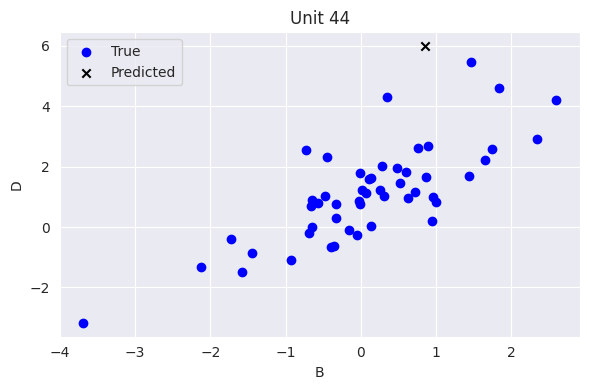

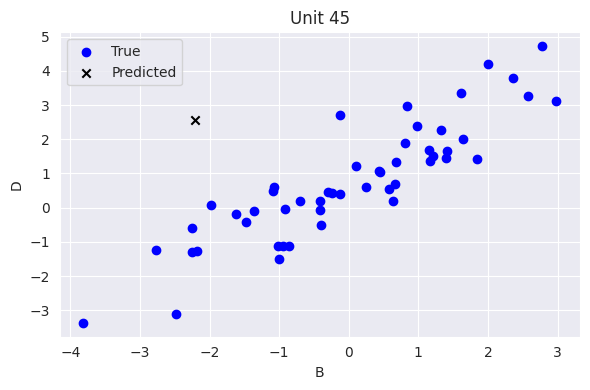

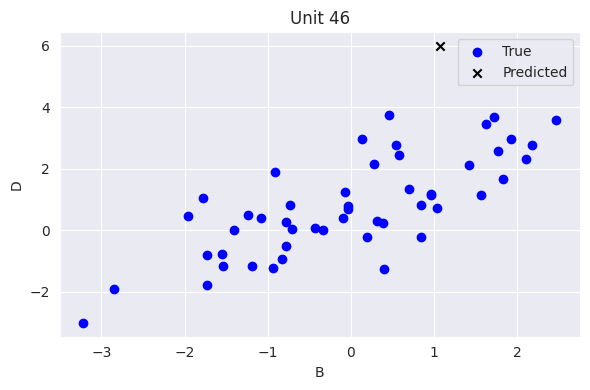

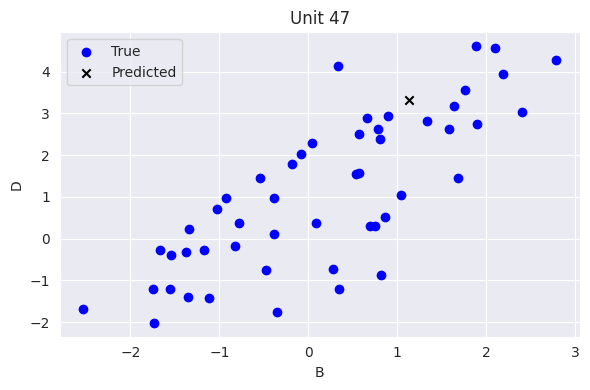

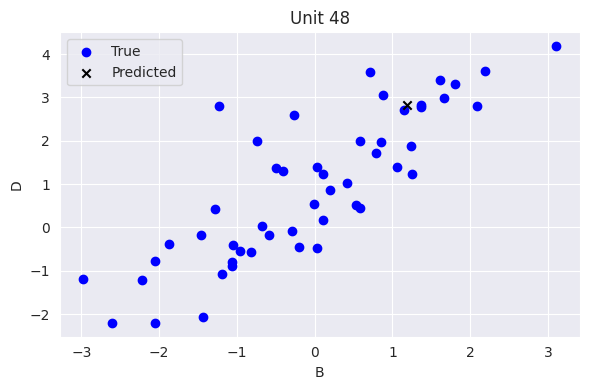

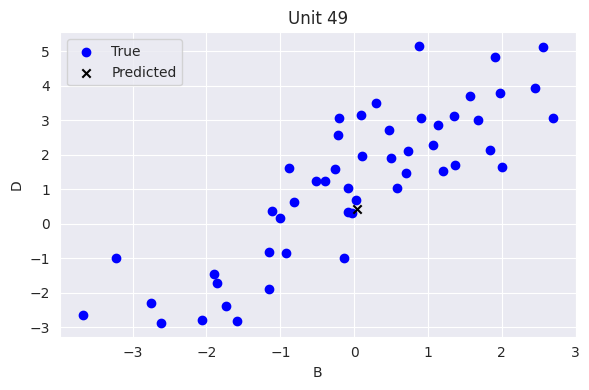

This code generates scatter plots for 50 units, comparing true and predicted values of B and D.
Each plot represents a single unit, with blue circles (o) for true values and black crosses (x) for predicted values.
The true values are taken from arrayB_full and arrayD_full, while predicted values come from b_array and d_array.
This visualization helps in understanding how well the predictions match the true values for each unit.


In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we have arrays arrayB_full, arrayD_full, b_array, and d_array
# arrayB_full and arrayD_full are the true values, b_array and d_array are the predicted values

# Colors for true and predicted values
true_color = 'blue'
pred_color = 'red'

for i in range(50):
    # Create a new figure for each unit
    plt.figure(figsize=(6, 4))
    
    # Plot true b and d values
    plt.scatter(arrayB_full[i,:], arrayD_full[i,:], color=true_color, label='True', marker='o')
    
    # Plot predicted b and d values
    # Check if the predicted values are scalars or arrays
    if np.isscalar(b_array[i]) and np.isscalar(d_array[i]):
        plt.scatter(b_array[i], d_array[i], color='black', label='Predicted', marker='x')
    else:
        plt.scatter(b_array[i], d_array[i], color='black', label='Predicted', marker='x')
    
    # Set title and labels for the plot
    plt.title(f'Unit {i}')
    plt.xlabel('B')
    plt.ylabel('D')
    plt.legend()
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Explanation of the code:
print("This code generates scatter plots for 50 units, comparing true and predicted values of B and D.")
print("Each plot represents a single unit, with blue circles (o) for true values and black crosses (x) for predicted values.")
print("The true values are taken from arrayB_full and arrayD_full, while predicted values come from b_array and d_array.")
print("This visualization helps in understanding how well the predictions match the true values for each unit.")


AUC ROC

In [37]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from scipy.special import kl_div


In [38]:


def experiment(n):
    kldivs = []
    roc_auc_scores = []
    
    for k in range(n):
        print(f"{k} is in progress")
        
        # Load data and set up the experiment
        graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
        data = load_data_from_json(f'data/sampled_data_{k}.json')
        
        unit_vars = ['a', 'c', 'e']
        subunit_vars = ['d', 'b']
        sizes = [50]*50
        
        generator = CausalGenerator(graph, data, unit_vars, subunit_vars, sizes)
        
        noise_dist = {
            'a': lambda x: norm.ppf(x),
            '_b': lambda x: norm.ppf(x, loc=0, scale=1),
            'c': lambda x: norm.ppf(x, loc=0, scale=1),
            '_d': lambda x: norm.ppf(x, loc=0, scale=1),
            'e': lambda x: norm.ppf(x, loc=0, scale=1)
        }
        
        transition_funcs = {
            '_b': lambda a: (a+1)**2,
            'c': lambda a, b: a**3 + (b+1)**2,
            '_d': lambda b, c: (b+1)**2 - c**3,
            'e': lambda c, d: c + (d+1)**2
        }
        
        generated_data = generator.generate(noise_dist, transition_funcs, sizes)
        
        # Generate arrays for each variable
        a_array = np.array([generated_data[f'a{i}'] for i in range(len(sizes))])
        b_array = np.array([generated_data[f'_b{i}'] for i in range(len(sizes))])
        c_array = np.array([generated_data[f'c{i}'] for i in range(len(sizes))])
        d_array = np.array([generated_data[f'_d{i}'] for i in range(len(sizes))])
        e_array = np.array([generated_data[f'e{i}'] for i in range(len(sizes))])
        
        # Get arrays from original data
        arrayA = np.array([data[f'a{i}'] for i in range(50)])
        arrayB = np.array([np.mean([data[f'_b{i}_{j}'] for j in range(50)]) for i in range(50)])
        arrayC = np.array([data[f'c{i}'] for i in range(50)])
        arrayD = np.array([np.mean([data[f'_d{i}_{j}'] for j in range(50)]) for i in range(50)])
        arrayE = np.array([data[f'e{i}'] for i in range(50)])
        
        # Calculate KL divergence
        kldiv = {
            'a': kl_divergence(arrayA, a_array),
            'b': kl_divergence(arrayB, b_array),
            'c': kl_divergence(arrayC, c_array),
            'd': kl_divergence(arrayD, d_array),
            'e': kl_divergence(arrayE, e_array)
        }
        kldivs.append(kldiv)
        
        # Prepare data for KNN classification
        X = np.concatenate([a_array, b_array, c_array, d_array, e_array, 
                            arrayA, arrayB, arrayC, arrayD, arrayE])
        y = np.concatenate([np.ones(len(a_array) * 5), np.zeros(len(arrayA) * 5)])
        
        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train.reshape(-1, 1), y_train)
        
        # Predict and calculate ROC AUC score
        y_pred = knn.predict_proba(X_test.reshape(-1, 1))[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred)
        roc_auc_scores.append(roc_auc)
        
        print(f"ROC AUC Score for iteration {k}: {roc_auc}")
    
    # Print average ROC AUC score
    avg_roc_auc = np.mean(roc_auc_scores)
    print(f"Average ROC AUC Score: {avg_roc_auc}")
    
    return kldivs, roc_auc_scores


0 is in progress
Data successfully loaded from data/sampled_data_0.json
ROC AUC Score for iteration 0: 0.6337126600284494
1 is in progress
Data successfully loaded from data/sampled_data_1.json
ROC AUC Score for iteration 1: 0.6222439544807965
2 is in progress
Data successfully loaded from data/sampled_data_2.json
ROC AUC Score for iteration 2: 0.6997688477951636
3 is in progress
Data successfully loaded from data/sampled_data_3.json
ROC AUC Score for iteration 3: 0.5956614509246088
4 is in progress
Data successfully loaded from data/sampled_data_4.json
ROC AUC Score for iteration 4: 0.6206436699857754
5 is in progress
Data successfully loaded from data/sampled_data_5.json
ROC AUC Score for iteration 5: 0.6573613086770982
6 is in progress
Data successfully loaded from data/sampled_data_6.json
ROC AUC Score for iteration 6: 0.6073079658605975
7 is in progress
Data successfully loaded from data/sampled_data_7.json
ROC AUC Score for iteration 7: 0.6477596017069701
8 is in progress
Data su

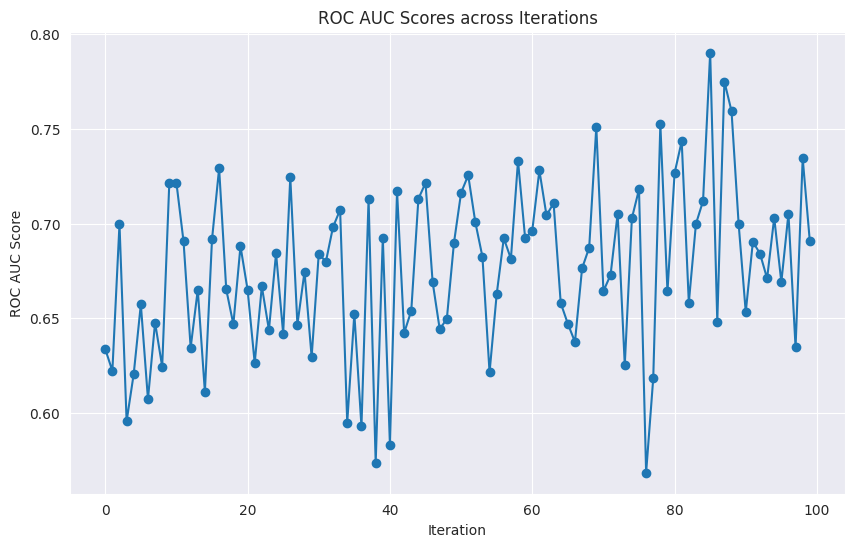

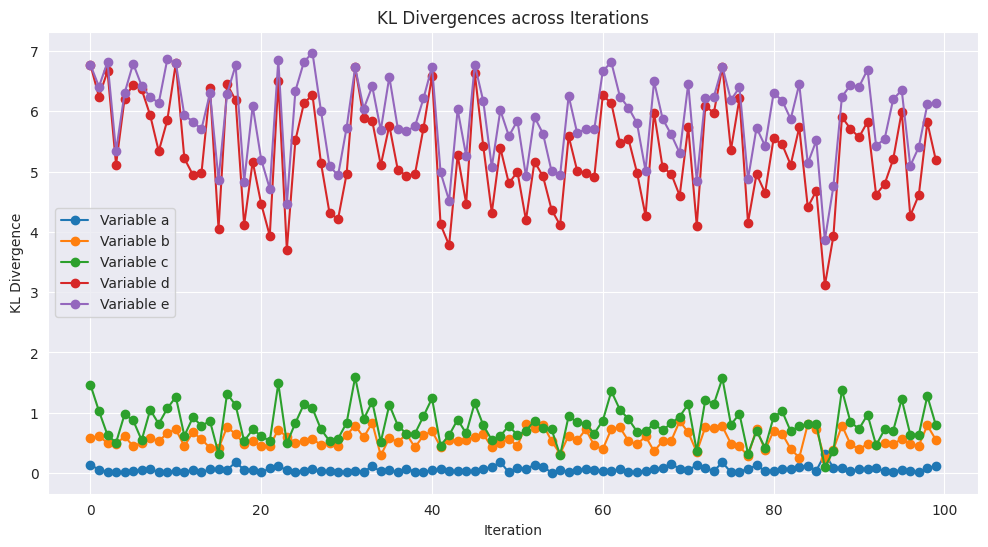

In [31]:

# Run the experiment
n_iterations = 100  # You can adjust this number
kldivs, roc_auc_scores = experiment(n_iterations)

# Plot ROC AUC scores
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), roc_auc_scores, marker='o')
plt.title('ROC AUC Scores across Iterations')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC Score')
plt.grid(True)
plt.show()

# Plot KL divergences
plt.figure(figsize=(12, 6))
for var in ['a', 'b', 'c', 'd', 'e']:
    kl_values = [kldiv[var] for kldiv in kldivs]
    plt.plot(range(n_iterations), kl_values, marker='o', label=f'Variable {var}')
plt.title('KL Divergences across Iterations')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.show()
